# Baselines (Secondary Structure Predictor)

In [1]:
# import the libraries
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

/root/venv/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 9.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
# import and see train_data.csv
df_train_csv = dd.read_csv('Data/train_data.csv')
df_train_csv.head()

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# apply SN-filter
df_sn = df_train_csv[df_train_csv["SN_filter"]==1]

# split into 2A3 MaP and DMS MaP datasets
df_2A3 = df_sn[df_sn["experiment_type"]=="2A3_MaP"]
df_DMS = df_sn[df_sn["experiment_type"]=="DMS_MaP"]

# split into train, validate, test
X_2A3 = df_2A3["sequence"]
y_2A3 = df_2A3.loc[:, df_2A3.columns.str.fullmatch("(sequence_id|reactivity_\d\d\d\d)")]
X_2A3_train_valid, X_2A3_test, y_2A3_train_valid, y_2A3_test = train_test_split(X_2A3, y_2A3, test_size=0.2, shuffle=True, blockwise=True, random_state=42)
X_2A3_train, X_2A3_valid, y_2A3_train, y_2A3_valid = train_test_split(X_2A3_train_valid, y_2A3_train_valid, test_size=0.25, shuffle=True, blockwise=True, random_state=42)

X_DMS = df_DMS["sequence"]
y_DMS = df_DMS.loc[:, df_DMS.columns.str.fullmatch("(sequence_id|reactivity_\d\d\d\d)")]
X_DMS_train_valid, X_DMS_test, y_DMS_train_valid, y_DMS_test = train_test_split(X_DMS, y_DMS, test_size=0.2, shuffle=True, blockwise=True, random_state=42)
X_DMS_train, X_DMS_valid, y_DMS_train, y_DMS_valid = train_test_split(X_DMS_train_valid, y_DMS_train_valid, test_size=0.25, shuffle=True, blockwise=True, random_state=42)

In [4]:
# import and see train_sequences.csv
df_test_csv = dd.read_csv('Data/test_sequences.csv')
df_test_csv.head()

,id_min,id_max,sequence_id,sequence,future
0,0,176,eee73c1836bc,GGGAACGACUCGAGUAGAGUCGAAAAUUUCCUUCCAAAUCCUGAGG...,0
1,177,353,d2a929af7a97,GGGAACGACUCGAGUAGAGUCGAAAAUGUAAUCAGAUUGCUUCUCC...,0
2,354,530,d39a4425ff45,GGGAACGACUCGAGUAGAGUCGAAAAAACACAUGAAUUUGAGGGUU...,0
3,531,707,1fc41e92d553,GGGAACGACUCGAGUAGAGUCGAAAAUCAGAGCUGGCAAAUGGAUG...,0
4,708,884,1d0826fb892f,GGGAACGACUCGAGUAGAGUCGAAAAUUUGGUAUUUGAUGCAUUAA...,0


In [5]:
# create mutate and map dataset
id1=269545321
id2=269724007
df_mmap = df_test_csv[(id1 <= df_test_csv["id_min"]) & (df_test_csv["id_max"] <= id2)].loc[:, ["sequence", "sequence_id"]]

In [6]:
# import and see p_unpaired.txt
df_p_unp_txt = dd.read_table('Data/p_unpaired.txt', header=None, delimiter=" ")
df_p_unp_txt.columns = ["sequence_id"] + [f"p_unp_{i}" for i in range(1,457+1)]
df_p_unp_txt.head()

,sequence_id,p_unp_1,p_unp_2,p_unp_3,p_unp_4,p_unp_5,p_unp_6,p_unp_7,p_unp_8,p_unp_9,...,p_unp_448,p_unp_449,p_unp_450,p_unp_451,p_unp_452,p_unp_453,p_unp_454,p_unp_455,p_unp_456,p_unp_457
0,1ea01090af2d,1.0,1.0,1.0,1.0,1.0,0.993046,1.0,1.0,0.998866,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,4e14f21eb896,1.0,1.0,1.0,1.0,1.0,0.993283,1.0,1.0,0.998641,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,73f4725d24bc,1.0,1.0,1.0,1.0,1.0,0.992327,1.0,1.0,0.998764,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,9d15ee40e0a2,1.0,1.0,1.0,1.0,1.0,0.991938,1.0,1.0,0.992982,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,f0c041f0d83c,1.0,1.0,1.0,1.0,1.0,0.992329,1.0,1.0,0.998781,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Secondary Structure Predictor Baseline

- Use P(unpaired) values from LinearPartition EternaFold Package

In [7]:
y_2A3_test.head()

,sequence_id,reactivity_0001,reactivity_0002,reactivity_0003,reactivity_0004,reactivity_0005,reactivity_0006,reactivity_0007,reactivity_0008,reactivity_0009,...,reactivity_0197,reactivity_0198,reactivity_0199,reactivity_0200,reactivity_0201,reactivity_0202,reactivity_0203,reactivity_0204,reactivity_0205,reactivity_0206
4506,8f1c41e7ea28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13110,4037ee958db5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37347,b405785842fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7381,3bfc3bb33f0b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9437,f1dc62e12137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 2A3 MAE
y_and_p_unp = y_2A3_test.merge(df_p_unp_txt, how="left", on="sequence_id")
y_val = y_and_p_unp.loc[:, y_and_p_unp.columns.str.fullmatch("reactivity_\d\d\d\d")]
p_unp_val = y_and_p_unp.loc[:, [f"p_unp_{i}" for i in range(1, 206+1)]]
p_unp_val.columns = y_val.columns
mean_absolute_error(y_val.clip(0, 1), p_unp_val)

0.4283191039767046

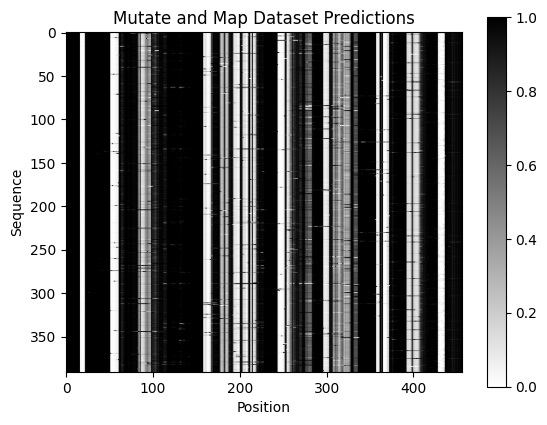

In [14]:
# 2A3 MMAP
mmap_and_p_unp = df_mmap.merge(df_p_unp_txt, how="left", on="sequence_id")
df_mmap_pred = mmap_and_p_unp.loc[:, [f"p_unp_{i}" for i in range(1, 457+1)]]
plt.imshow(df_mmap_pred.compute(), vmin=0,vmax=1, cmap='gray_r')
plt.colorbar()
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

In [15]:
# DMS MAE
y_and_p_unp = y_DMS_test.merge(df_p_unp_txt, how="left", on="sequence_id")
y_val = y_and_p_unp.loc[:, y_and_p_unp.columns.str.fullmatch("reactivity_\d\d\d\d")]
p_unp_val = y_and_p_unp.loc[:, [f"p_unp_{i}" for i in range(1, 206+1)]]
p_unp_val.columns = y_val.columns
mean_absolute_error(y_val.clip(0, 1), p_unp_val)

0.4372353461652444

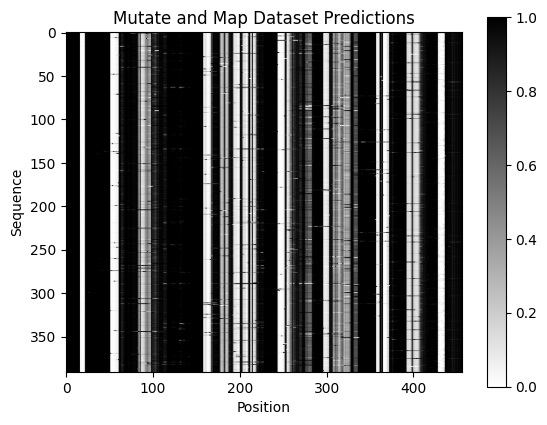

In [16]:
# DMS MMAP
mmap_and_p_unp = df_mmap.merge(df_p_unp_txt, how="left", on="sequence_id")
df_mmap_pred = mmap_and_p_unp.loc[:, [f"p_unp_{i}" for i in range(1, 457+1)]]
plt.imshow(df_mmap_pred.compute(), vmin=0,vmax=1, cmap='gray_r')
plt.colorbar()
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fe343e39-d2c0-4296-915d-091d9a42752d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>